In [268]:
import geopandas as gpd
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


from hidden_config import Config

Use API key and credentials to query Socrata database

In [376]:
url = "data.cityofchicago.org"
client = Socrata(url,
                 Config.API_KEY,
                 username=Config.USERNAME,
                 password=Config.PASSWORD)

red_light_violations_uri = 'spqx-js37'
speed_camera_violations_uri = 'hhkd-xvj4'

red_light_violations_list = client.get(red_light_violations_uri, limit=10000)
speed_camera_violations_list = client.get(speed_camera_violations_uri, limit=10000)

red_light_violations_df = pd.DataFrame(red_light_violations_list)
speed_camera_violations_df = pd.DataFrame(speed_camera_violations_list)


### Data Cleansing
Cast the columns to their proper data types

In [379]:
speed_camera_violations_df['violations'] = speed_camera_violations_df['violations'].astype(float)
red_light_violations_df['violations'] = red_light_violations_df['violations'].astype(float)

speed_camera_violations_df['violation_date'] = pd.to_datetime(speed_camera_violations_df['violation_date'])
red_light_violations_df['violation_date'] = pd.to_datetime(red_light_violations_df['violation_date'])

speed_camera_violations_df['violation_day_of_week'] = speed_camera_violations_df['violation_date'].dt.strftime('%A')
red_light_violations_df['violation_day_of_week'] = pd.to_datetime(red_light_violations_df['violation_date']).dt.strftime('%A')


### Temporal Analysis
Let's see how the number of violations trends over time.

They add more cameras over time, so we need to calculate how many new cameras there have been.

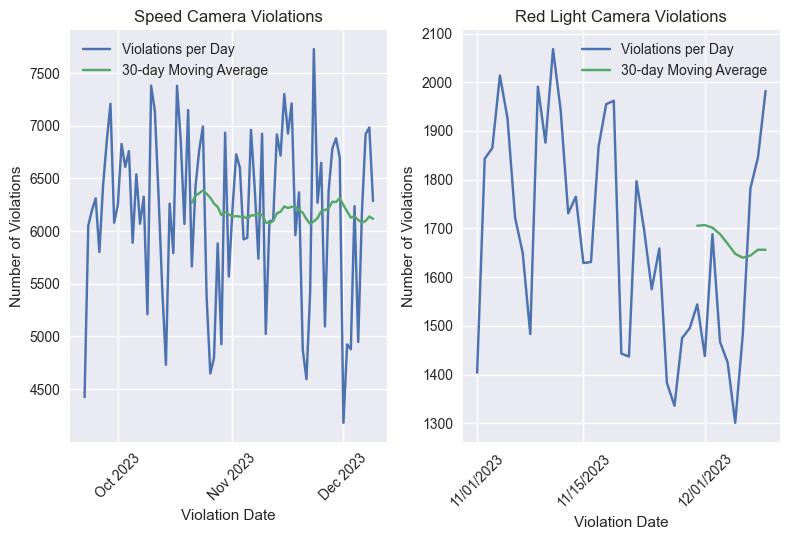

In [382]:
speed_camera_violations_df['30_day_ma'] = speed_camera_violations_df['violations'].rolling(window=30).mean()

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

ax[0].plot(speed_camera_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

speed_camera_daily_sum = pd.DataFrame(speed_camera_violations_df.groupby('violation_date')['violations'].sum())
speed_camera_ma = speed_camera_daily_sum.rolling(window=30).mean()
ax[0].plot(speed_camera_ma['violations'], label='30-day Moving Average')


ax[0].tick_params(axis='x', rotation=45)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[0].set_xticks(ax[0].get_xticks()[::2])
ax[0].set_xlabel('Violation Date')
ax[0].set_ylabel('Number of Violations')
ax[0].set_title('Speed Camera Violations')
ax[0].legend()

ax[1].plot(red_light_violations_df.groupby('violation_date')['violations'].sum(), label='Violations per Day')

red_light_daily_sum = pd.DataFrame(red_light_violations_df.groupby('violation_date')['violations'].sum())
red_light_ma = red_light_daily_sum.rolling(window=30).mean()
ax[1].plot(red_light_ma['violations'], label='30-day Moving Average')


ax[1].tick_params(axis='x', rotation=45)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax[1].set_xticks(ax[1].get_xticks()[::2])
ax[1].set_xlabel('Violation Date')
ax[1].set_ylabel('Number of Violations')
ax[1].set_title('Red Light Camera Violations')
ax[1].legend()
plt.tight_layout()
plt.show()



DoW Analysis

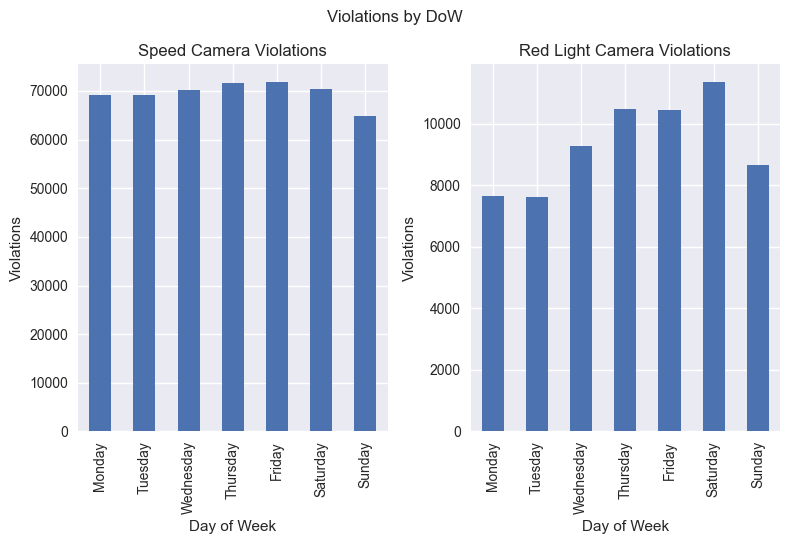

In [381]:
# Sum violations by day of week
speed_camera_violations_by_dow = speed_camera_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Do the same for red light cameras
red_light_violations_by_dow = red_light_violations_df.groupby(['violation_day_of_week'])['violations'].sum()

# Create a Categorical data type with the desired order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_order = pd.CategoricalDtype(categories=day_order, ordered=True)

speed_camera_violations_by_dow.index = speed_camera_violations_by_dow.index.astype(cat_order)
red_light_violations_by_dow.index = red_light_violations_by_dow.index.astype(cat_order)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2)

speed_camera_violations_by_dow.sort_index().plot(kind='bar', ax=ax[0])
red_light_violations_by_dow.sort_index().plot(kind='bar', ax=ax[1])

ax[0].set_xlabel('Day of Week')
ax[0].set_ylabel('Violations')
ax[0].set_title('Speed Camera Violations')

ax[1].set_xlabel('Day of Week')
ax[1].set_ylabel('Violations')
ax[1].set_title('Red Light Camera Violations')

fig.suptitle('Violations by DoW')
plt.tight_layout()
plt.show()


In [31]:
# Read the GeoJSON data from the boundaries shapefiles. 
chicago_communities = gpd.read_file('chicago_communities')

In [77]:
# Extract the latitude and longitude values from the 'location' column
red_light_violations_df['latitude'] = red_light_violations_df['location'].apply(lambda x: x['latitude'] if isinstance(x, dict) and 'latitude' in x else None)
red_light_violations_df['longitude'] = red_light_violations_df['location'].apply(lambda x: x['longitude'] if isinstance(x, dict) and 'longitude' in x else None)

